In [15]:
!pip install matplotlib requests gensim pymorphy3 scikit-learn bs4 nltk numpy

In [1]:
import requests
from bs4 import BeautifulSoup
from gensim.models import Word2Vec
import numpy as np
import re
import pymorphy3
import nltk
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from collections import defaultdict
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Егор\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
url = 'https://otzovik.com/reviews/bank_tinkoff_kreditnie_sistemi/'

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.36"
}

In [ ]:
response_texts = []
response_values = []
response_dates = []

In [ ]:
for page_number in range(1, 423):
    if page_number != 1:
        url1 = url + str(page_number) + '/'
    else:
        url1 = url

    page = requests.get(url1, headers=headers)

    soup = BeautifulSoup(page.text, 'lxml')

    url_to_full_response = soup.select("div.item-right > div.review-body-wrap > h3 > a")

    for i in range(len(url_to_full_response)):
        url_to_full_response1 = url_to_full_response[i].split
        url_to_full_response1 = 'https://' + url_to_full_response1[2][6:-1]

        page_full_response = requests.get(url_to_full_response1, headers=headers)
        soup1 = BeautifulSoup(page_full_response.text, 'lxml')

        response_value = soup1.select("div.item-right > div.rating-wrap > div[class='rating-score tooltip-right'] > span")
        response_values.append(response_value[0].text)

        rev_topic = soup1.select("div.item-right > h1")
        rev_topic = rev_topic[0].text

        rev_plus = soup1.select("div.item-right > div.review-plus")
        rev_plus = rev_plus[0].text

        rev_minus = soup1.select("div.item-right > div.review-minus")
        rev_minus = rev_minus[0].text

        rev_text = soup1.select("div.item-right > div[class='review-body description']")
        rev_text = rev_text[0].text

        all_rev_text = rev_topic + ' ' + rev_plus + ' ' + rev_minus + ' ' + rev_text

        response_texts.append(all_rev_text)

        rev_date = soup1.select("div.item-right > div.rating-wrap > span[class='review-postdate dtreviewed'] > span")
        response_dates.append(rev_date[0].text)


In [ ]:
morph = pymorphy3.MorphAnalyzer()
stopwords = nltk.corpus.stopwords.words('russian')
stopwords.extend(['документ', 'номер', 'тинькофф', "отзыв", "недостаток", "достоинство", "банк"])


In [ ]:
def cl_text(text):
    c = text.lower()
    c = re.sub(r'crm[^\n]+', '', c)
    c = re.sub(r'\n+', ' ', c)
    c = re.sub(r'\s+', ' ', c)
    c = re.sub(r"[A-Za-z!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+", ' ', c)
    return c.strip()

In [ ]:
def lemmatize(text):
    tokens = []
    text = re.sub(r"\d+", '', text.lower()) 
    for token in text.split():
        token = token.strip()
        token = morph.normal_forms(token)[0].replace('ё', 'е')
        if token and token not in stopwords: tokens.append(token)
    if len(tokens) > 2: tokens = ' '.join(tokens)
    return tokens

In [ ]:
for i in range(len(response_texts)):
    response_texts[i] = cl_text(response_texts[i])
    response_texts[i] = lemmatize(response_texts[i])

In [ ]:
word2vec_model = Word2Vec(sentences=response_texts, vector_size=100, window=5, min_count=1, workers=4)

In [ ]:
def document_vector(word2vec_model, doc):
    doc = [word for word in doc if word in word2vec_model.wv.key_to_index]
    return np.mean(word2vec_model.wv[doc], axis=0)

In [ ]:
X = [document_vector(word2vec_model, doc) for doc in response_texts]
X = np.nan_to_num(X)

In [ ]:
kmeans = KMeans(n_clusters=5) #можно менять
kmeans.fit(X)
kmeans_clusters = kmeans.labels_

In [ ]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(response_texts)

In [ ]:
un_clust = sorted(list(set(kmeans_clusters)))

In [ ]:
for cluster_idx in un_clust:
    cluster_indices = np.where(kmeans_clusters == cluster_idx)[0]
    cluster_texts = [response_texts[i] for i in cluster_indices]
    cluster_tfidf = tfidf_matrix[cluster_indices].mean(axis=0)
    cluster_tfidf = np.asarray(cluster_tfidf).reshape(-1)
    
    significant_indices = np.argpartition(cluster_tfidf, -10)[-10:]

    significant_words = [tfidf_vectorizer.get_feature_names_out()[i] for i in significant_indices]

In [ ]:
good_resp = response_values.count("5") + response_values.count("4")
bad_resp = response_values.count("2") + response_values.count("1")
neutral_resp = response_values.count("3")
num_resp = len(response_values)

In [ ]:
print(f"Положительных отзывов {good_resp}, это {good_resp / num_resp * 100}% от общего количества.")
print(f"Отрицательных отзывов {bad_resp}, это {bad_resp / num_resp * 100}% от общего количества.")
print(f"Нейтральных отзывов {neutral_resp}, это {neutral_resp / num_resp * 100}% от общего количества.")

In [50]:
diagram = []
kmeans_clusters = list(kmeans_clusters)

In [51]:
for i in un_clust:
    diagram.append(kmeans_clusters.count(i))

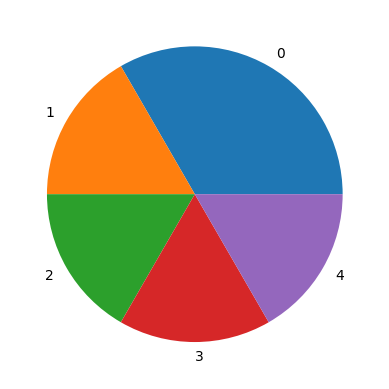

In [52]:
plt.pie(diagram, labels=un_clust)
plt.show()

In [ ]:
print("Самые частые слова для каждого кластера:")
for i in un_clust:
    print(f"Кластер {i}, самые частые слова: {top_words[i]}.")

In [34]:
positive_resp = defaultdict(int)
neutral_resp = defaultdict(int)
negative_resp = defaultdict(int)

In [35]:
dat_to_dat = {"янв":"01", "фев":"02", "мар":"03", "апр":"04", "мая":"05", "июн":"06", "июл":"07", "авг":"08", "сен":"09", "окт":"10", "ноя":"11", "дек":"12"}

In [36]:
resp_count = len(response_dates)

In [37]:
for i in range(resp_count):
    date = response_dates[i].split()
    year_month = date[2] + '-' + dat_to_dat[date[1]]
    if int(response_values[i]) > 3:
        positive_resp[year_month] += 1
    elif int(response_values[i]) < 3:
        negative_resp[year_month] += 1
    else:
        neutral_resp[year_month] += 1

In [38]:
x = list(positive_resp.keys()) 
y_positive = list(positive_resp.values())
y_neutral = [neutral_resp[month] for month in x]
y_negative = [negative_resp[month] for month in x]

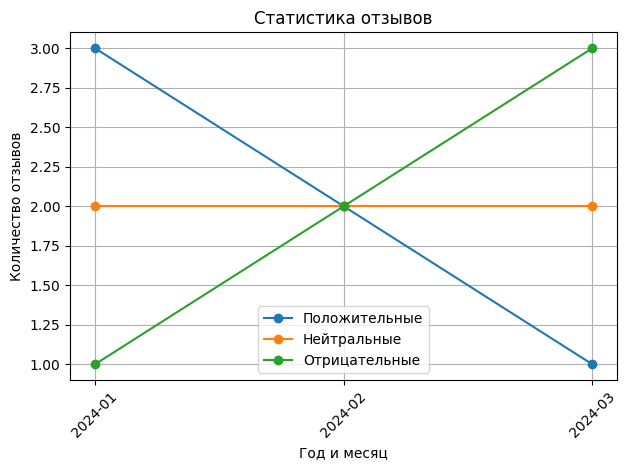

In [39]:
plt.plot(x, y_positive, label='Положительные', marker='o')
plt.plot(x, y_neutral, label='Нейтральные', marker='o')
plt.plot(x, y_negative, label='Отрицательные', marker='o')

plt.xlabel('Год и месяц')
plt.ylabel('Количество отзывов')
plt.title('Статистика отзывов')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()
